In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import time
from dds_loopback import DDSOverlay

In [2]:
ol = DDSOverlay(bitfile_name='hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit',dbg=True,plot=False,n_buffers=1,download=False)

loading bitfile hw/top_dac_feedthrough_dual_frontend_w_spi_trig_select.bit


In [22]:
ol.shutdown_dac()

setting cos_scale to 15 (90dB attenuation)


In [5]:
ol.set_dac_atten_dB(12)
ol.set_vga_atten_dB(18)
ol.set_sample_buffer_trigger_source('manual')
ol.set_freq_hz(1100e6)
#ol.set_sample_buffer_trigger_source('dds_auto')
#ol.set_freq_hz(800e6)
#ol.dma(0)
#fig, ax = plt.subplots(2,1)
#ax[0].plot(ol.dma_buffers[0][:4096,0])
#ax[1].plot(ol.dma_buffers[0][:4096,1])

setting cos_scale to 2 (12dB attenuation)
setting vga attenuation to 18dB
setting pinc to 4505600 (1.100e+09Hz)


setting vga attenuation to 24dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 1388544 (3.390e+08Hz)
spurs = [[133.78500073 184.47911597]
 [ 86.752474   192.65906628]]
dt = 1.394552778861122
[ 50.69411524 105.90659228]


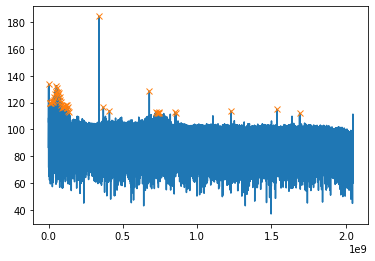

In [26]:
# sfdr test
ol.set_adc_source('afe')
ol.set_sample_buffer_trigger_source('manual')
t1 = ol.timer.read_count()
ol.set_vga_atten_dB(24)
ol.set_dac_atten_dB(12)
ol.set_freq_hz(339e6)
time.sleep(0.01)
ol.manual_trigger()
time.sleep(0.01)
ol.dma(0)
ol.plot = True
ol.dbg = True
sfdr = ol.sfdr_dBc(0)
t2 = ol.timer.read_count()
dt = ol.timer.time_it(t1, t2)
print(f'dt = {dt}')
print(sfdr)

setting vga attenuation to 20dB
setting cos_scale to 0 (0dB attenuation)
setting pinc to 937984 (2.290e+08Hz)
sinad = [41.28451324 98.09313573], psignal = [2.49400882e+08 5.36855331e+08], pnoise = [1.85543892e+04 8.32805716e-02]
dt = 3.3536344763447636


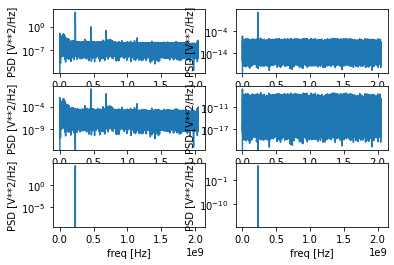

In [3]:
# snr test
ol.set_adc_source('afe')
ol.set_sample_buffer_trigger_source('manual')
t1 = ol.timer.read_count()
ol.set_vga_atten_dB(20)
ol.set_dac_atten_dB(0)
freq = 229e6
ol.set_freq_hz(freq)
time.sleep(0.01)
ol.manual_trigger()
time.sleep(0.01)
ol.dma(0)
ol.plot = True
ol.dbg = True
sinad, psignal, pnoise = ol.sinad_dBc(0)
print(f'sinad = {sinad}, psignal = {psignal}, pnoise = {pnoise}')
t2 = ol.timer.read_count()
dt = ol.timer.time_it(t1, t2)
print(f'dt = {dt}')

In [3]:
# short sweep to get a few interesting waveforms
ol.plot = False
ol.dbg = False
config_order = ['vga_atten_dB', 'dac_atten_dB', 'freq_hz', 'src']
configs = [
    # vga atten, dac atten, freq, src
    [16, 12, 1e6, 'afe'],
    [0, 0, 1e6, 'balun'],
    [8, 12, 1e6, 'afe'],
    [32, 42, 1e6, 'afe'],
    [24, 24, 200e6, 'afe'],
    [0, 0, 200e6, 'balun'],
    [0, 30, 200e6, 'balun'],
    [8, 12, 200e6, 'afe'],
    [32, 42, 200e6, 'afe'],
    [16, 18, 1400e6, 'afe'],
    [0, 0, 1400e6, 'balun'],
    [0, 6, 1400e6, 'balun'],
    [0, 12, 1400e6, 'balun'],
    [0, 18, 1400e6, 'balun'],
    [24, 36, 1400e6, 'afe'],
    [24, 12, 1900e6, 'afe'],
    [8, 0, 1900e6, 'afe'],
    [24, 36, 1900e6, 'afe'],
    [0, 0, 1900e6, 'balun'],
    [0, 6, 1900e6, 'balun'],
    [0, 12, 1900e6, 'balun'],
    [0, 18, 1900e6, 'balun']
]
N_avg = 4
data = np.zeros((ol.dma_frame_shape[0], len(configs), N_avg))
t1 = time.time()
ol.set_sample_buffer_trigger_source('manual')
for c,config in enumerate(configs):
    print(f'testing config: {config}, {round(c/len(configs)*100)}% done')
    for n in range(N_avg):
        ol.set_freq_hz(config[2])
        ol.set_adc_source(config[3])
        ol.set_dac_atten_dB(config[1])
        ol.set_vga_atten_dB(config[0])
        time.sleep(0.01)
        ol.manual_trigger()
        ol.dma(0)
        time.sleep(0.01)
        data[:,c,n] = ol.dma_buffers[0][:,0] # only save analog waveform

t2 = time.time()
print(f'took {round(t2-t1)}s to complete sweep')
scipy.io.savemat('data/afe_vs_balun_interesting_sfdr_points.mat', {'config_order': config_order, 'configs': configs, 'data': data})

testing config: [16, 12, 1000000.0, 'afe'], 0% done
testing config: [0, 0, 1000000.0, 'balun'], 5% done
testing config: [8, 12, 1000000.0, 'afe'], 9% done
testing config: [32, 42, 1000000.0, 'afe'], 14% done
testing config: [24, 24, 200000000.0, 'afe'], 18% done
testing config: [0, 0, 200000000.0, 'balun'], 23% done
testing config: [0, 30, 200000000.0, 'balun'], 27% done
testing config: [8, 12, 200000000.0, 'afe'], 32% done
testing config: [32, 42, 200000000.0, 'afe'], 36% done
testing config: [16, 18, 1400000000.0, 'afe'], 41% done
testing config: [0, 0, 1400000000.0, 'balun'], 45% done
testing config: [0, 6, 1400000000.0, 'balun'], 50% done
testing config: [0, 12, 1400000000.0, 'balun'], 55% done
testing config: [0, 18, 1400000000.0, 'balun'], 59% done
testing config: [24, 36, 1400000000.0, 'afe'], 64% done
testing config: [24, 12, 1900000000.0, 'afe'], 68% done
testing config: [8, 0, 1900000000.0, 'afe'], 73% done
testing config: [24, 36, 1900000000.0, 'afe'], 77% done
testing confi

In [ ]:
# sfdr/sinad sweep at various frequencies
ol.plot = False
ol.dbg = False
plot_sweep = True
vga_atten_settings = np.linspace(0,32,5)
dac_atten_settings = np.linspace(0,60,11)
#freqs = np.array([1e6, 10e6, 100e6, 200e6, 500e6, 800e6, 1e9, 1.2e9, 1.5e9, 1.7e9, 1.9e9])
freqs = np.array([1e6, 50e6, 200e6, 900e6, 1.4e9, 1.9e9])
N_avg = 5
sfdr = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
sfdr_limit = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
sinad = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
sinad_limit = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
pnoise = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
pnoise_limit = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
psignal = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
psignal_limit = np.zeros((len(freqs), len(dac_atten_settings), len(vga_atten_settings), 2, N_avg))
ol.set_sample_buffer_trigger_source('manual')
t1 = time.time()
for s,src in enumerate(['afe', 'balun']):
    ol.set_adc_source(src)
    for f,freq in enumerate(freqs):
        ol.set_freq_hz(freq)
        print(f'testing SFDR at freq {round(freq/1e6)}MHz, {round(f/len(freqs)*100/2+s*50)}% done')
        for d,dac_atten_dB in enumerate(dac_atten_settings):
            ol.set_dac_atten_dB(dac_atten_dB)
            for v,vga_atten_dB in enumerate(vga_atten_settings):
                ol.set_vga_atten_dB(vga_atten_dB)
                for a in range(N_avg):
                    time.sleep(0.01) # extra sleep
                    ol.manual_trigger()
                    ol.dma(0)
                    # get SFDR
                    sfdr_calc = ol.sfdr_dBc(0)
                    sfdr[f,d,v,s,a] = sfdr_calc[0]
                    sfdr_limit[f,d,v,s,a] = sfdr_calc[1]
                    # get SINAD, noise power and signal power
                    sinad_calc, psignal_calc, pnoise_calc = ol.sinad_dBc(0)
                    sinad[f,d,v,s,a] = sinad_calc[0]
                    sinad_limit[f,d,v,s,a] = sinad_calc[1]
                    psignal[f,d,v,s,a] = psignal_calc[0]
                    psignal_limit[f,d,v,s,a] = psignal_calc[1]
                    pnoise[f,d,v,s,a] = pnoise_calc[0]
                    pnoise_limit[f,d,v,s,a] = pnoise_calc[1]
                    
                if src == 'balun':
                    # vga atten doesn't do anything for balun
                    break
        plt.figure()
        v,d = np.meshgrid(vga_atten_settings, dac_atten_settings)
        plt.pcolor(v, d, np.median(sfdr[f,:,:,s,:],axis=2))
        plt.colorbar()
        plt.gca().set_aspect('equal')
        plt.title(f'{src} SFDR at {round(freq/1e6)}MHz')
        plt.xlabel('VGA attenuation')
        plt.ylabel('DAC attenuation')
t2 = time.time()
data_dict = {
    'vga_atten_dB': vga_atten_settings,
    'dac_atten_dB': dac_atten_settings,
    'freqs_hz': freqs,
    'src': ['afe', 'balun'],
    'sfdr_dBc': sfdr,
    'sfdr_limit_dBc': sfdr_limit,
    'sinad_dBc': sinad,
    'sinad_limit_dBc': sinad_limit,
    'pnoise_analog_lsb': pnoise,
    'pnoise_digital_lsb': pnoise_limit,
    'psignal_analog_lsb': psignal,
    'psignal_digital_lsb': psignal_limit,
}
scipy.io.savemat('data/afe_vs_balun_sfdr_sinad.mat', data_dict)
print(f'took {round(t2-t1)}s to complete sweep')

testing SFDR at freq 1MHz, 0% done
testing SFDR at freq 50MHz, 8% done
testing SFDR at freq 200MHz, 17% done
testing SFDR at freq 900MHz, 25% done
testing SFDR at freq 1400MHz, 33% done


setting vga attenuation to 24dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 2048000 (5.000e+08Hz)


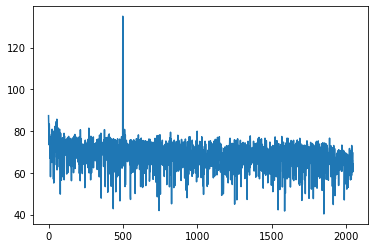

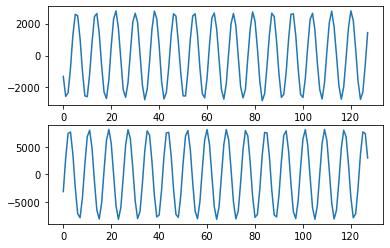

In [13]:
# send something just to test signal path and make sure everything is connected up
ol.set_vga_atten_dB(24)
ol.set_dac_atten_dB(12)
ol.set_adc_source('afe')
ol.set_sample_buffer_trigger_source('manual')
ol.set_freq_hz(500e6)
ol.manual_trigger()
ol.dma(0)
time.sleep(0.1)
fft = 20*np.log10(abs(np.fft.rfft(ol.dma_buffers[0][:4096,:], axis=0))+1)[1:-1,:]
plt.figure()
plt.plot(fft[:,0])
fig,ax = plt.subplots(2,1)
ax[0].plot(ol.dma_buffers[0][:128,0])
ax[1].plot(ol.dma_buffers[0][:128,1])

Text(0.5, 0, 'freq [Hz]')

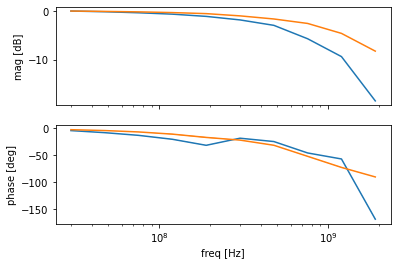

In [41]:
# full loopback configuration:
# 0: RFSoC DAC -> AFE DAC buffer -> AFE ADC buffer -> RFSoC ADC ('adc')
# 1: RFSoC DAC -> RFSoC ADC ('balun')
# "adaptive" reference tone
fig, ax = plt.subplots(2,1,sharex=True)
mags_norm = raw_mags/np.max(raw_mags,axis=0)
mags_mean = np.median(mags_norm,axis=1)
mags_std = np.std(mags_norm,axis=1)
mags_dB = 20*np.log10(mags_mean)
mags_dB_low = 20*np.log10(mags_mean-mags_std)
mags_dB_high = 20*np.log10(mags_mean+mags_std)
ax[0].plot(freqs,mags_dB)
ax[0].fill_between(freqs,mags_dB_low[:,0],mags_dB_high[:,0],alpha=0.9)
ax[0].fill_between(freqs,mags_dB_low[:,1],mags_dB_high[:,1],alpha=0.9)
ax[0].set_ylabel('mag [dB]')
wrapped_phases = raw_phases*180/np.pi
#wrapped_phases[(wrapped_phases > 180)] -= 360
phase_mean = -np.median(wrapped_phases,axis=1)
phase_std = -np.std(wrapped_phases,axis=1)
ax[1].plot(freqs,phase_mean)
ax[1].fill_between(freqs,phase_mean[:,0]-phase_std[:,0],phase_mean[:,0]+phase_std[:,0],alpha=0.9)
ax[1].fill_between(freqs,phase_mean[:,1]-phase_std[:,1],phase_mean[:,1]+phase_std[:,1],alpha=0.9)
ax[1].set_ylabel('phase [deg]')
plt.xscale('log')
plt.xlabel('freq [Hz]')
#plt.xlim([30e6, 1900e6])
#plt.ylim([-50, 5])

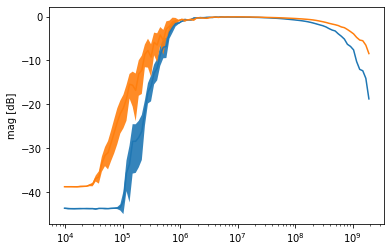

In [51]:
# full loopback configuration:
# 0: RFSoC DAC -> AFE DAC buffer -> AFE ADC buffer -> RFSoC ADC ('adc')
# 1: RFSoC DAC -> RFSoC ADC ('balun')
# "adaptive" reference tone
mags_norm = raw_mags/np.max(raw_mags,axis=0)
mags_mean = np.median(mags_norm,axis=1)
mags_std = np.std(mags_norm,axis=1)
mags_dB = 20*np.log10(mags_mean)
mags_dB_low = 20*np.log10(mags_mean-mags_std)
mags_dB_high = 20*np.log10(mags_mean+mags_std)
plt.plot(freqs,mags_dB)
plt.fill_between(freqs,mags_dB_low[:,0],mags_dB_high[:,0],alpha=0.9)
plt.fill_between(freqs,mags_dB_low[:,1],mags_dB_high[:,1],alpha=0.9)
plt.ylabel('mag [dB]')
plt.xscale('log')

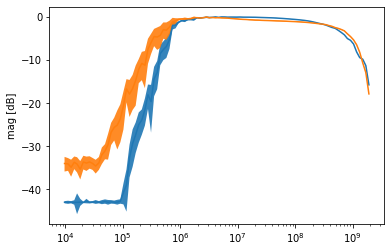

In [9]:
# partial loopback configuration:
# 0: RFSoC DAC -> AFE ADC buffer -> RFSoC ADC ('adc')
# 1: RFSoC DAC -> RFSoC ADC ('balun')
mags_norm = raw_mags/np.max(raw_mags,axis=0)
mags_mean = np.median(mags_norm,axis=1)
mags_std = np.std(mags_norm,axis=1)
mags_dB = 20*np.log10(mags_mean)
mags_dB_low = 20*np.log10(mags_mean-mags_std)
mags_dB_high = 20*np.log10(mags_mean+mags_std)
plt.plot(freqs,mags_dB)
plt.fill_between(freqs,mags_dB_low[:,0],mags_dB_high[:,0],alpha=0.9)
plt.fill_between(freqs,mags_dB_low[:,1],mags_dB_high[:,1],alpha=0.9)
plt.ylabel('mag [dB]')
plt.xscale('log')

In [8]:
# fine-grained frequency sweep measurement of gain
ol.dbg = False
ol.plot = False
# sweep parameters
N_freqs = 100
N_avg = 30
vga_atten_dB = 18 # best settings for SFDR
dac_atten_dB = 12
freqs = np.floor((np.logspace(np.log10(10e3), np.log10(1900e6), N_freqs)/ol.f_samp)*2**ol.phase_bits)*ol.f_samp/2**ol.phase_bits
raw_mags = np.zeros((N_freqs,N_avg,2))
t1 = time.time()
ol.set_vga_atten_dB(vga_atten_dB)
ol.set_dac_atten_dB(dac_atten_dB)
ol.set_sample_buffer_trigger_source('manual')
print(f'starting sweep, estimated time is ~{N_freqs*N_avg/7}s ({round(N_freqs*N_avg/7)//60}:{round(N_freqs*N_avg/14)%60})')
for i,freq in enumerate(freqs):
    print(f'starting frequency {round(freq/1e6,3)}MHz ({round(i/len(freqs)*100)}% done)')
    for j in range(N_avg):
        for k,src in enumerate(['afe','balun']):
            ol.set_adc_source(src)
            ol.set_freq_hz(freq)
            ol.manual_trigger()
            ol.dma(0)
            time.sleep(0.01)
            raw_mags[i,j,k] = np.std(scipy.signal.resample_poly(np.array(ol.dma_buffers[0][4096:8192,0],dtype=np.float32),32,1,axis=0))
t2 = time.time()
scipy.io.savemat('data/afe_adcbufonly_vs_balun_gain_lowend_freq_response.mat', {'vga_atten_dB': vga_atten_dB, 'dac_atten_dB': dac_atten_dB, 'freqs_hz': freqs, 'raw_mags_au': raw_mags})
print(f'took {round((t2-t1))}s to perform {N_freqs*N_avg*2} measurements ({N_freqs*N_avg*2/round(t2-t1)} measurements/s)')

starting sweep, estimated time is ~428.57142857142856s (7:34)
starting frequency 0.01MHz (0% done)
starting frequency 0.011MHz (1% done)
starting frequency 0.013MHz (2% done)
starting frequency 0.014MHz (3% done)
starting frequency 0.016MHz (4% done)
starting frequency 0.018MHz (5% done)
starting frequency 0.021MHz (6% done)
starting frequency 0.023MHz (7% done)
starting frequency 0.027MHz (8% done)
starting frequency 0.03MHz (9% done)
starting frequency 0.034MHz (10% done)
starting frequency 0.039MHz (11% done)
starting frequency 0.043MHz (12% done)
starting frequency 0.049MHz (13% done)
starting frequency 0.056MHz (14% done)
starting frequency 0.063MHz (15% done)
starting frequency 0.071MHz (16% done)
starting frequency 0.081MHz (17% done)
starting frequency 0.091MHz (18% done)
starting frequency 0.103MHz (19% done)
starting frequency 0.116MHz (20% done)
starting frequency 0.132MHz (21% done)
starting frequency 0.149MHz (22% done)
starting frequency 0.168MHz (23% done)
starting frequ

tones = [20000000. 30000000.]
measuring phase delay of frequency 30MHz with reference 20MHz
setting vga attenuation to 18dB
setting cos_scale to 2 (12dB attenuation)
setting pinc to 81920 (2.000e+07Hz)
setting pinc to 122880 (3.000e+07Hz)
n_intersect = [2152 1452]
t_intersect = [5.25390625e-07 3.54492187e-07]
coarse_delay_n = 700
uncertainty = 205 = 50.048828125ns
lags[np.argmax(xcorr)] = -204 = -1.59375*128
fine_delay_n_correction = 89396 = 698.40625*128
phi = 0.0755006169037464 (4.32586669921875 deg)
phi = 0.0755006169037464 = 4.32586669921875 deg
ampl = 16193.4140625
dt = 4.4855616092681885


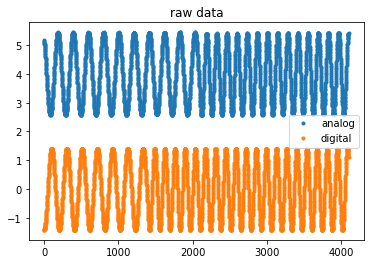

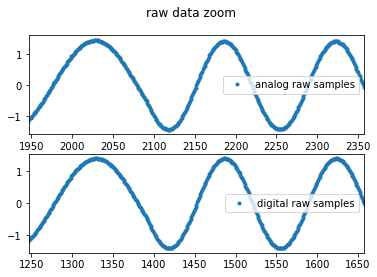

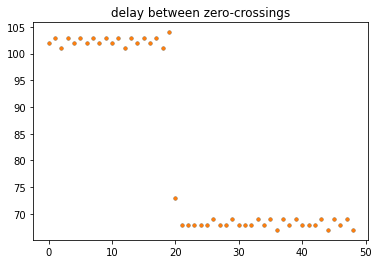

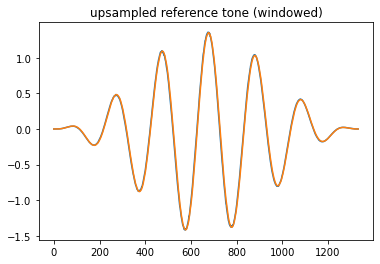

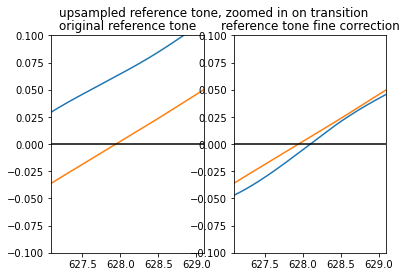

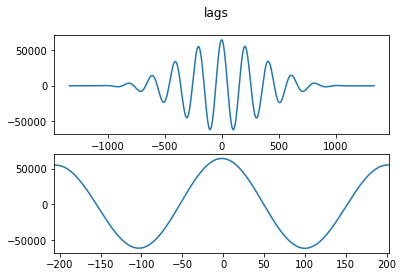

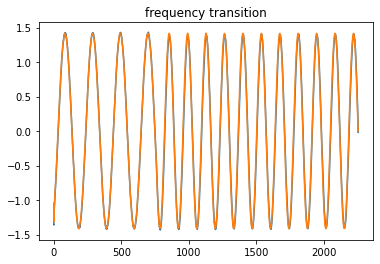

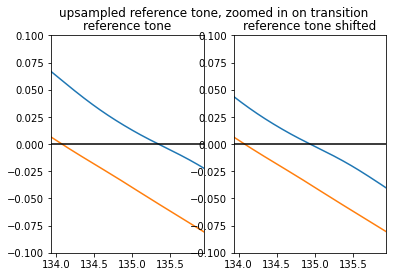

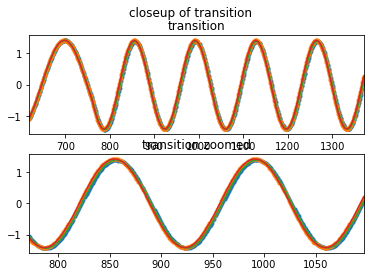

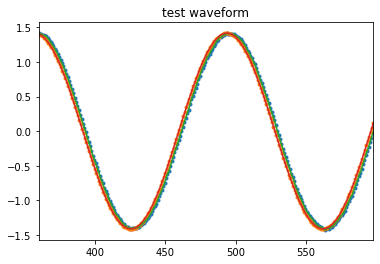

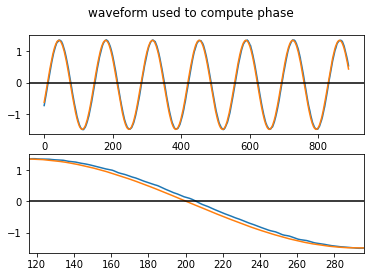

In [38]:
ol.dbg = True
ol.plot = True
OSR = 128
tones = np.floor((np.array([20e6, 30e6])/ol.f_samp)*2**ol.phase_bits)*ol.f_samp/2**ol.phase_bits
print(f'tones = {tones}')
vga_atten_dB = 18
dac_atten_dB = 0
t1 = time.time()
phi = ol.measure_phase('afe', tones, OSR, vga_atten_dB, dac_atten_dB)
ampl = np.std(scipy.signal.resample_poly(np.array(ol.dma_buffers[0][4096:8192,0],dtype=np.float32),32,1,axis=0))
t2 = time.time()
print(f'phi = {phi} = {phi*180/np.pi} deg')
print(f'ampl = {ampl}')
print(f'dt = {t2-t1}')

In [40]:
# fine-grain frequency sweep measurement of magnitude and phase
ol.dbg = False
ol.plot = False
# phase estimation parameters
OSR = 128
# sweep parameters
N_freqs = 10
N_avg = 3
vga_atten_dB = 18 # best settings for SFDR
dac_atten_dB = 12
freqs = np.floor((np.logspace(np.log10(30e6), np.log10(1900e6), N_freqs)/ol.f_samp)*2**ol.phase_bits)*ol.f_samp/2**ol.phase_bits
ref_tones = np.where(freqs >= 500e6, 200e6, np.where(freqs >= 200e6, 100e6, 20e6))
raw_phases = np.zeros((N_freqs,N_avg,2))
raw_mags = np.zeros((N_freqs,N_avg,2))
print(f'starting sweep, estimated time is ~{N_freqs*N_avg}s ({(N_freqs*N_avg)//60}:{(N_freqs*N_avg)%60})')
t1 = time.time()
for i,freq in enumerate(freqs):
    tones = np.array([ref_tones[i], freq])
    print(f'starting frequency {round(ref_tones[i]/1e6)}->{round(freq/1e6,3)}MHz ({round(i/len(freqs)*100)}% done)')
    for j in range(N_avg):
        for k,src in enumerate(['afe','balun']):
            success = False
            while not success:
                try:
                    raw_phases[i,j,k] = ol.measure_phase(src,tones,OSR,vga_atten_dB,dac_atten_dB)
                    success = True
                except ValueError:
                    success = False
            raw_mags[i,j,k] = np.std(scipy.signal.resample_poly(np.array(ol.dma_buffers[0][4096:8192,0],dtype=np.float32),32,1,axis=0))
t2 = time.time()
scipy.io.savemat('data/afe_vs_balun_freq_response_shifting_reftone.mat', {'vga_atten_dB': vga_atten_dB, 'dac_atten_dB': dac_atten_dB, 'freqs_hz': freqs, 'ref_tones_hz': ref_tones, 'raw_phases_rad': raw_phases, 'raw_mags_au': raw_mags})
print(f'took {round((t2-t1))}s to perform {N_freqs*N_avg*2} measurements ({N_freqs*N_avg*2/round(t2-t1)} measurements/s)')

starting sweep, estimated time is ~30s (0:30)
starting frequency 20->30.0MHz (0% done)
starting frequency 20->47.567MHz (10% done)
starting frequency 20->75.419MHz (20% done)
starting frequency 20->119.582MHz (30% done)
starting frequency 20->189.604MHz (40% done)
starting frequency 100->300.627MHz (50% done)
starting frequency 100->476.661MHz (60% done)
starting frequency 200->755.772MHz (70% done)
starting frequency 200->1198.318MHz (80% done)
starting frequency 200->1900.0MHz (90% done)
took 53s to perform 60 measurements (1.1320754716981132 measurements/s)
